# Quantum Simulation via Superconducting Quantum Hardware

In [41]:
from qiskit import *
from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

import warnings
warnings.filterwarnings('ignore')

In [42]:
from qiskit import IBMQ
IBMQ.save_account("26595118309e0ea848015d3f7458b040ec723a9c11afd2d777038533a5a2b8079312af1e3713e370053f85bf7dd5d77f72993b0f04c2cd561e4c31f5a40c910c")
IBMQ.load_account()

configrc.store_credentials:WARNING:2021-05-20 22:17:31,932: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-05-20 22:17:32,630: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [43]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')
properties = backend.properties()

The Hamiltonian we consider 

$H=V\sum_{\left\langle i,j\right\rangle }Z_{i}Z_{j}+\Omega\sum_{i}X_{i}+h\sum_{i}Z_{i}$

In [44]:
#def h_Z(qc,h,dt):
#    for i in range(5):
#        qc.rz(2*h*dt,i)

def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt):
    for i in range(5):
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt):
    #for i in range(5):
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)
    

In [45]:
def Trotter_circuit_5_site(h,Omega,V,T,n):
    Trotter_circuits = []
    dt=T/n
    for i in range(n):
        Trotter_circuit = QuantumCircuit(5)
        Trotter_circuit.x(1)
        Trotter_circuit.x(3)
        #Trotter_circuit.x(4)
        Trotter_circuit.barrier()
        for k in range(i):
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        Trotter_circuits.append(Trotter_circuit)
    return Trotter_circuits
    
    

In [46]:
Omega = 0.2*2
h = 2*2
V = 1*2
T = 5 # Total time 
TT=T
n = 20
NN=n
Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

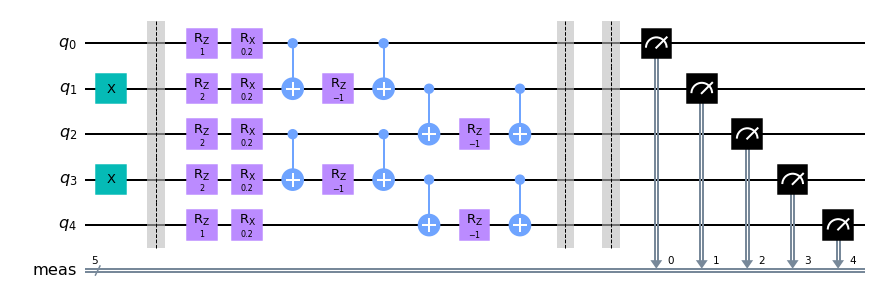

In [47]:
Trotter_circuit[1].draw(output = "mpl")

In [48]:
qr = QuantumRegister(5)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')



In [49]:
shots = 8192
il = [0,1,2,3,4]
Trotter_circuit_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), shots=shots, initial_layout=il)

Trotter_result = execute(Trotter_circuit, backend, shots=shots, initial_layout=il)

Trotter_mit  = execute(meas_calibs, backend, shots=shots, initial_layout=il)

In [50]:

job_monitor(Trotter_result)

Job Status: job has successfully run


In [51]:
result_counts = Trotter_mit.result()

results = Trotter_result.result()

In [52]:
cal_results = Trotter_mit.result()

In [53]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[9.17724609e-01 2.86865234e-02 3.52783203e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.03759766e-02 9.25537109e-01 2.44140625e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.69775391e-02 8.54492188e-04 9.26635742e-01 ... 0.00000000e+00
  1.22070312e-04 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.33374023e-01
  3.66210938e-04 3.34472656e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.44140625e-04
  8.31542969e-01 2.42919922e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.45263672e-02
  8.17871094e-03 8.17016602e-01]]


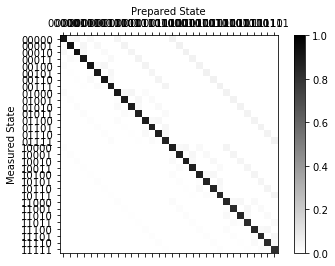

In [54]:
meas_fitter.plot_calibration()

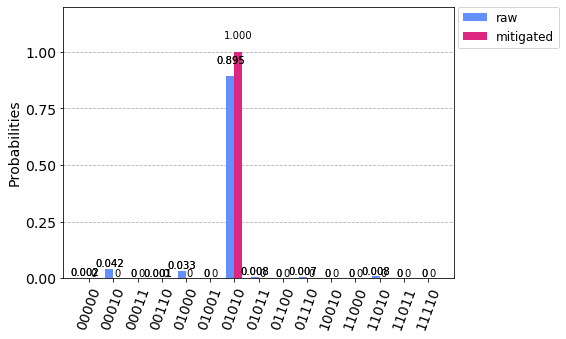

In [55]:
from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np

Result_nomit = results.get_counts(0) 
mitigated_counts = meas_fitter.filter.apply(results).get_counts(0)
plot_histogram([Result_nomit, mitigated_counts], legend=['raw', 'mitigated'])

In [56]:
tot=np.zeros(5)

for i in range(2**5):
    n=2**5
    if i in Result_nomit.int_outcomes():
        a=bin(n+i)[3:]
        c= ' '
        tot+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_nomit.int_outcomes()[i]
tot/8192

array([-0.98120117,  0.90576172, -0.98120117,  0.92724609, -0.98291016])

In [57]:
Sz_nomit = []
Sz_mit = []
for i in range(NN):
    tot_nomit=np.zeros(5)
    tot_mit=np.zeros(5)
    Result_nomit = results.get_counts(i) 
    mitigated_counts = meas_fitter.filter.apply(results).get_counts(i)
    for j in range(2**5):
        n=2**5
        if j in Result_nomit.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_nomit+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_nomit.int_outcomes()[j] 
        if j in mitigated_counts.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_mit+=(2*np.array(c.join(a).split()).astype(int)-1)*mitigated_counts.int_outcomes()[j]
    Sz_nomit.append(tot_nomit/8192)
    Sz_mit.append(tot_mit/8192)
Sz_nomit=np.array(Sz_nomit)
Sz_mit=np.array(Sz_mit)

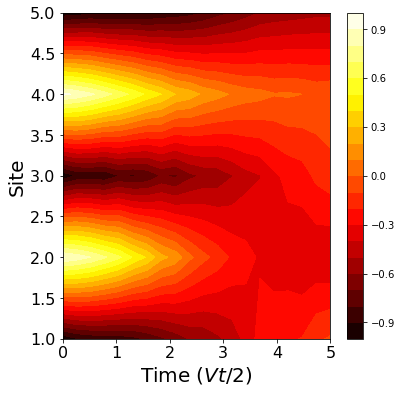

In [58]:
t=np.linspace(0,TT,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_nomit), 20, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(V t/2)$', fontsize =20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()



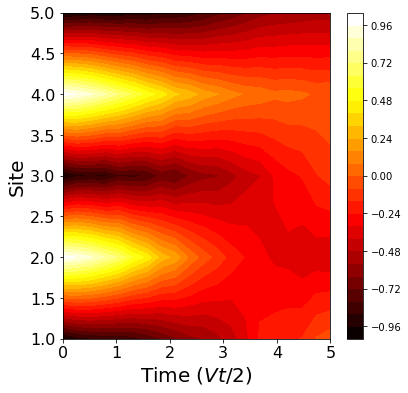

In [59]:
t=np.linspace(0,TT,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_mit), 30, vmin=-1, vmax=1, cmap='hot')
#ax = sns.heatmap(np.transpose(Sz_mit), cbar=0, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(V t/2)$', fontsize =20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [60]:
result_sim=Trotter_circuit_sim.result()

In [61]:
Sz_sim = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim = result_sim.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim.int_outcomes()[j] 
    Sz_sim.append(tot_sim/8192)
Sz_sim=np.array(Sz_sim)

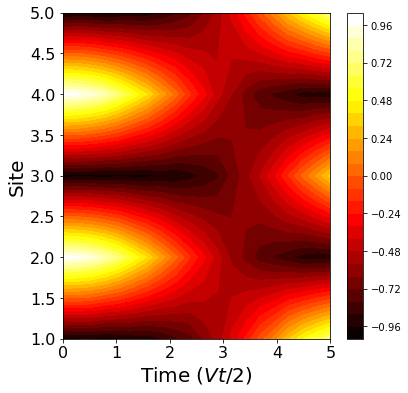

In [62]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(V t/2)$', fontsize =20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

# Classical simulation

In [63]:
import scipy.linalg as la

def flip(n,i,L): 
    # Flip the i site spin in n-state with system size L
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))


def binaryToDecimal(binary): 
    # change the binary number into decimal number
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

def spin_x(i,L):
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

def spin_y(i,L):
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

def spin_z(i,L):
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[2:][::-1][i])-1
    return Z



In [64]:
L=5

Omega=0.2*2
h=2*2 #2*2
V=1*2


H0=0
for i in range(L):
    H0=H0+Omega*spin_x(i,L) # Rabi coupling
    
H1=0
H1=H1+h*spin_z(0,L)/2
H1=H1+h*spin_z(L-1,L)/2
for i in range(L-2):
    H1=H1+h*spin_z(i+1,L) 


V0=0
for i in range(L-1):
    n_f=spin_z((i)%L,L)
    n_b=spin_z((i+1)%L,L)
    V0=V0+V*np.dot(n_f,n_b)


H=H0+V0+H1

In [65]:
M=H
vals, vecs = la.eigh(M)

inds=np.argsort(vals)
e=vals[inds]
v=vecs[:,inds]

In [66]:
binaryToDecimal(1010)

10

In [67]:
Nt=20-1
T=5
dt=T/Nt

A=np.eye(len(e))*e
U=np.dot(v,np.dot(np.exp(-1j*A*dt)*np.eye(len(e)),np.conj(np.transpose(v))))

f = 10

wavefunc=np.zeros((len(e),Nt+1),dtype=complex)
n=np.zeros(len(e),dtype=complex)
n[f]=1
wavefunc[:,0]=n
for i in range(Nt):
    wavefunc[:,i+1]=np.dot(U,wavefunc[:,i])


In [68]:
def Zi_t_p(tf,dt,f,i):
  
  
    Nt=tf/dt
    Nt=int(Nt)

    Zt=spin_z(i,L)
    Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),np.dot(Zt,wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=np.stack(Zt1,axis=0)
    return Zt1

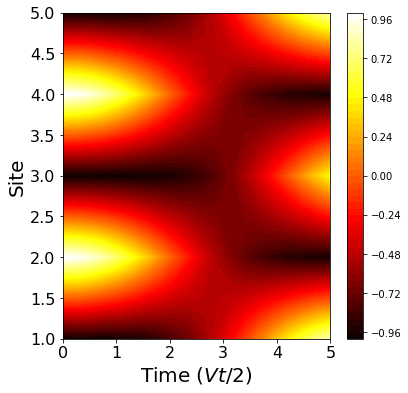

In [69]:
Zi=np.zeros((L,Nt+1))
for i in range(L):
    Zi[i,:]=np.real(Zi_t_p(T,dt,f,i))
t=np.linspace(0,T,Nt+1)
l=np.linspace(1,L,L)
T, LL = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(T, LL, Zi, 50, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(V t/2)$', fontsize =20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [70]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [71]:
#Create the file to record the information of qubits
f=open('qubits_info_manila.txt','w')
num_qubits=5
for i in range(num_qubits):
    f.write('qubit_'+str(i)+':')
    print('qubit_'+str(i)+':')
    f.write('\n')
    f.write('T1: '+str(properties.to_dict()['qubits'][i][0]['value'])+' us')
    print('T1: '+str(properties.to_dict()['qubits'][i][0]['value'])+' us')
    f.write('\n')
    f.write('T2: '+str(properties.to_dict()['qubits'][i][1]['value'])+' us')
    print('T2: '+str(properties.to_dict()['qubits'][i][1]['value'])+' us')
    f.write('\n')
    f.write('Frequency: '+str(properties.to_dict()['qubits'][i][2]['value'])+' GHZ')
    print('Frequency: '+str(properties.to_dict()['qubits'][i][2]['value'])+' GHZ')
    f.write('\n')
    f.write('anharmonicity: '+str(properties.to_dict()['qubits'][i][3]['value'])+' GHZ')
    print('anharmonicity: '+str(properties.to_dict()['qubits'][i][3]['value'])+' GHZ')
    f.write('\n')
    f.write('prob_meas0_prep1: '+str(properties.to_dict()['qubits'][i][5]['value']))
    print('prob_meas0_prep1: '+str(properties.to_dict()['qubits'][i][5]['value']))
    f.write('\n')
    f.write('prob_meas1_prep0: '+str(properties.to_dict()['qubits'][i][6]['value']))
    print('prob_meas1_prep0: '+str(properties.to_dict()['qubits'][i][6]['value']))
    f.write('\n')
    f.write('readout_length: '+str(properties.to_dict()['qubits'][i][7]['value'])+' ns')
    print('readout_length: '+str(properties.to_dict()['qubits'][i][7]['value'])+' ns')
    f.write('\n')
f.close()

qubit_0:
T1: 131.5672599220194 us
T2: 104.92464935636448 us
Frequency: 4.9627387574803175 GHZ
anharmonicity: -0.3433479504893883 GHZ
prob_meas0_prep1: 0.02859999999999996
prob_meas1_prep0: 0.0152
readout_length: 5351.11111111111 ns
qubit_1:
T1: 227.36714690891702 us
T2: 92.36292425254291 us
Frequency: 4.838429112586749 GHZ
anharmonicity: -0.3462116492210585 GHZ
prob_meas0_prep1: 0.0298
prob_meas1_prep0: 0.012800000000000034
readout_length: 5351.11111111111 ns
qubit_2:
T1: 126.45108784754389 us
T2: 22.739919563342525 us
Frequency: 5.036909379693178 GHZ
anharmonicity: -0.34366028709148855 GHZ
prob_meas0_prep1: 0.0262
prob_meas1_prep0: 0.0046
readout_length: 5351.11111111111 ns
qubit_3:
T1: 239.86948372529648 us
T2: 71.31473728794798 us
Frequency: 4.951306052737605 GHZ
anharmonicity: -0.3435523612547686 GHZ
prob_meas0_prep1: 0.033399999999999985
prob_meas1_prep0: 0.014
readout_length: 5351.11111111111 ns
qubit_4:
T1: 157.7794321741474 us
T2: 47.77012566795856 us
Frequency: 5.0663510302431

In [72]:
#Create the file to record the information of qubits
f1=open('gates_info_manila.txt','w')
num_qubits=5
for i in range(num_qubits):
    f1.write('qubit_'+str(i)+'gate :')
    print("qubit"+str(i)+' gate :')
    f1.write('\n')
    f1.write('SX_gate error rate '+str(properties.to_dict()['gates'][10+i]['parameters'][0]['value']))
    print('SX_gate error rate '+str(properties.to_dict()['gates'][10+i]['parameters'][0]['value']))
    f1.write('\n')
    f1.write('SX_gate length '+str(properties.to_dict()['gates'][10+i]['parameters'][1]['value'])+' ns')
    print('SX_gate length '+str(properties.to_dict()['gates'][10+i]['parameters'][1]['value'])+' ns')
    f1.write('\n')
    f1.write('X_gate error rate '+str(properties.to_dict()['gates'][15+i]['parameters'][0]['value']))
    print('X_gate error rate '+str(properties.to_dict()['gates'][15+i]['parameters'][0]['value']))
    f1.write('\n')
    f1.write('X_gate length '+str(properties.to_dict()['gates'][15+i]['parameters'][1]['value'])+' ns')
    print('X_gate length '+str(properties.to_dict()['gates'][15+i]['parameters'][1]['value'])+' ns')
    f1.write('\n')
for i in range(2*(num_qubits-1)):
    f1.write('qubit_'+str(properties.to_dict()['gates'][20+i]['qubits'])+' gate :')
    print('qubit_'+str(properties.to_dict()['gates'][20+i]['qubits'])+' gate :')
    f1.write('\n')
    f1.write('Cnot_gate error rate '+str(properties.to_dict()['gates'][20+i]['parameters'][0]['value']))
    print('Cnot_gate error rate '+str(properties.to_dict()['gates'][20+i]['parameters'][0]['value']))
    f1.write('\n')
    f1.write('Cnot_gate length '+str(properties.to_dict()['gates'][20+i]['parameters'][1]['value'])+' ns')
    print('Cnot_gate length '+str(properties.to_dict()['gates'][20+i]['parameters'][1]['value'])+' ns')
f1.close()

qubit0 gate :
SX_gate error rate 0.0001980905095390239
SX_gate length 35.55555555555556 ns
X_gate error rate 0.0001980905095390239
X_gate length 35.55555555555556 ns
qubit1 gate :
SX_gate error rate 0.0003554477072089106
SX_gate length 35.55555555555556 ns
X_gate error rate 0.0003554477072089106
X_gate length 35.55555555555556 ns
qubit2 gate :
SX_gate error rate 0.00023226815958421194
SX_gate length 35.55555555555556 ns
X_gate error rate 0.00023226815958421194
X_gate length 35.55555555555556 ns
qubit3 gate :
SX_gate error rate 0.0001901534538160099
SX_gate length 35.55555555555556 ns
X_gate error rate 0.0001901534538160099
X_gate length 35.55555555555556 ns
qubit4 gate :
SX_gate error rate 0.0005242597555358627
SX_gate length 35.55555555555556 ns
X_gate error rate 0.0005242597555358627
X_gate length 35.55555555555556 ns
qubit_[4, 3] gate :
Cnot_gate error rate 0.009502811264258781
Cnot_gate length 298.66666666666663 ns
qubit_[3, 4] gate :
Cnot_gate error rate 0.009502811264258781
Cnot_